## Importing Libraries

In [3]:
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from keras.preprocessing import image
import random

## Data Prepration 

In [4]:
Dataset_path=Path("./Dataset/")
Folders=Dataset_path.glob('*')
label_map={"Cat":0,"Dog":1,"Horse":2,"Human":3}
image_data=[]
labels=[]

for folder in Folders:
    label=str(folder).split("\\")[-1]
    for img in folder.glob('*.jpg'):
        Image=image.load_img(img,target_size=(30,30))
        Image=image.img_to_array(Image)
        image_data.append(Image)
        labels.append(label_map[label])


### Shuffling Data

In [5]:
Combined_data=list(zip(image_data,labels))
random.shuffle(Combined_data)
image_data,labels=list(zip(*Combined_data))

image_data=np.array(image_data,dtype="int32")
labels=np.array(labels,dtype="int32")
print(image_data.shape,labels.shape)

(808, 30, 30, 3) (808,)


### Visulizing Shuffled data

0 ->


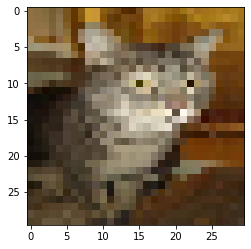

3 ->


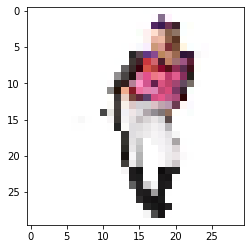

3 ->


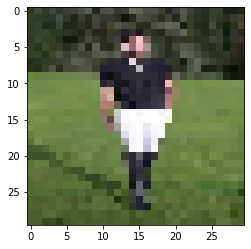

2 ->


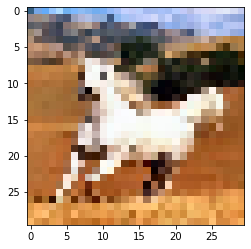

2 ->


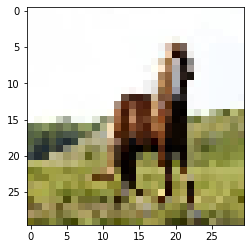

1 ->


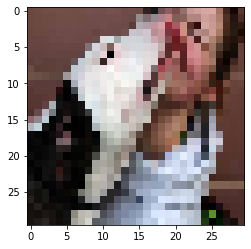

2 ->


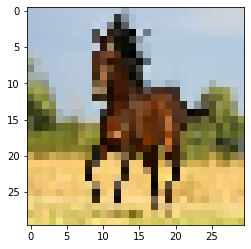

2 ->


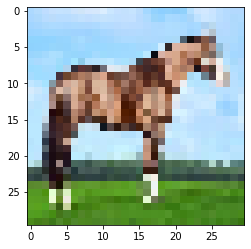

2 ->


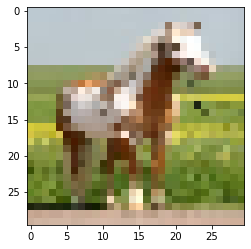

3 ->


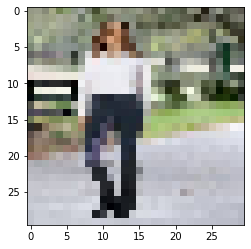

In [6]:
for i in range(10):
    print(labels[i],"->")
    plt.imshow(image_data[i])
    plt.show()

### Class Wise Data

In [81]:
data={}
num_class=len(np.unique(labels))

for classes in range(num_class):
    data[classes]=[]

for data_idx in range(image_data.shape[0]):
    data[labels[data_idx]].append(image_data[data_idx])

for data_idx in range(num_class):
    data[data_idx]=np.array(data[data_idx])

### One vs One Classification Using SVM

In [ ]:
def PairData(Data1,Data2):
    """Combines data of two class and returns with label for SVM"""
    
    size1=Data1.shape[0]
    size2=Data2.shape[0]
    total_data=size1+size2
    num_features=Data1.shape[1]

    Processed_data=np.zeroes((total_data,num_features))
    Processed_label=np.zeroes((total_data,))

    Processed_data[:size1,:]=Data1
    Processed_data[size1:,:]=Data2

    Processed_label[:size1]=1
    Processed_label[size1:]=-1

    return Processed_data,Processed_label



